# Evaluation

## Preliminaries

### Imports

In [47]:
import sys
import os
sys.path.append('./src')

In [48]:
import pickle
import bz2

In [49]:
from joblib import Parallel
from joblib import delayed
from joblib import parallel_backend

In [50]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [51]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

In [52]:
import pandas as pd

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    v_measure_score,
    silhouette_score,
    calinski_harabasz_score,
)

In [54]:
import numpy as np

In [55]:
import torch

In [56]:
import random

### Constants and global variables

In [57]:
SPLITS = ('train', 'validation', 'test')
MODELS = ('Pretrained', 'Fine-Tuned')
DATA_SETS = ('DailyDialog', 'EmpatheticDialogues', 'Persona-Chat', 'Wizard of Wikipedia', 'HOPE')
DISTRIBUTIONS = ('latent_prior_dist', 'latent_posterior_dist')
HIDDEN_VECTORS = ('prior_hidden_state', 'posterior_hidden_state')

In [58]:
DATA_PATH = '../resources/data/cache/'
PROCESSED_DATA_PATHS = (
    '../experiments/DLDLM_evaluation/dldlm_large_nllt_lda_lr_2022_11_10_22_41_08/data', 
    '../experiments/DLDLM_evaluation/dldlm_large_nllt_gibbs_2022_11_11_09_54_42/data'
)

In [59]:
N_LATENTS = 16

In [60]:
N_COMPONENTS = 1280

In [61]:
N_REPETITIONS = 100

In [62]:
DISTRIBUTION_MAP = {'latent_prior_dist': 'Prior', 'latent_posterior_dist': 'Posterior'}
DIALOGUE_ACT_MAP = {
    'Clarification Request': 'Clarification Request',
    'Opinion Request': 'Opinion Request',
    'Information Request': 'Information Request',
    'Yes/No question': 'Yes/No Question',
    'Greeting': 'Greeting',
    'Acknowledgement': 'Acknowledgement',
    'General Chat': 'General Chat',
    'Information Delivery': 'Information Delivery',
    'Positive Answer': 'Positive Answer',
    'Clarification Delivery': 'Clarification Delivery',
    'Negative Answer': 'Negative Answer',
    'Opinion Delivery': 'Opinion Delivery'
}
DIALOGUE_ACT_TYPE_MAP = {
    'Clarification Request': 'Speaker Initiative',
    'Opinion Request': 'Speaker Initiative',
    'Information Request': 'Speaker Initiative',
    'Yes/No question': 'Speaker Initiative',
    'Greeting': 'General',
    'Acknowledgement': 'General',
    'General Chat': 'General',
    'Information Delivery': 'Speaker Responsive',
    'Positive Answer': 'Speaker Responsive',
    'Clarification Delivery': 'Speaker Responsive',
    'Negative Answer': 'Speaker Responsive',
    'Opinion Delivery': 'Speaker Responsive'
}
SENTIMENT_MAP = {'Very negative': 'Very Negative', 'Negative': 'Negative', 'Neutral': 'Neutral', 'Positive': 'Positive', 'Very Positive': 'Very Positive'}
SPEAKER_MAP = {'Therapist': 'Therapist', 'Patient': 'Patient'}

In [63]:
TOP_WORDS = 20

In [64]:
DIALOGUE_ACT_ENCODER = {value: i for i, value in enumerate(DIALOGUE_ACT_MAP.values())}
DIALOGUE_ACT_TYPE_ENCODER = {value: i for i, value in enumerate(DIALOGUE_ACT_TYPE_MAP.values())}
SENTIMENT_ENCODER = {value: i for i, value in enumerate(SENTIMENT_MAP.values())}
SPEAKER_ENCODER = {value: i for i, value in enumerate(SPEAKER_MAP.values())}
CORPUS_ENCODER = {value: i for i, value in enumerate(DATA_SETS)}

In [65]:
RANDOM_SEED = 2307

### Random seed

In [66]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Helper functions

In [67]:
def load_data(path):
    # Open the BZIP2 file
    with bz2.BZ2File(path, 'r') as f:
        # Read the content with Pickle
        data = pickle.load(f)
    # Return loaded data
    return data

In [68]:
def group_by(data, group):
    # Initialise a dictionary to store the groups
    grouped_data = {value: [] for value in {sample[group] for sample in data}}
    # Go through the data set and add each sample to the correct group
    for sample in data:
        if sample[group] in grouped_data:
            grouped_data[sample[group]].append(sample)
        else:
            grouped_data[sample[group]]= [sample]
    # Return grouped data
    return grouped_data

In [69]:
def compute_metadata(data):
    # Helper function to compute the desired info on a single sample
    def get_metadata(sample):
        return {'corpus': sample['corpus'], 'conversation_idx': sample['conversation_idx'], 'n_tokens': len(word_tokenize(sample['response']))}
    # Define parallel backend to compute the desired metadata
    with parallel_backend('threading', n_jobs=-1):
        # Compute No. of tokens for each turn of each dialogue in each corpus (mantaing the splitting info)
        metadata = Parallel(verbose=0)(delayed(get_metadata)(sample) for sample in data)
    # Return computed metadata
    return metadata

In [70]:
def compute_stats(data):
    # Group data by dialogue identifier
    grouped_data = group_by(data, 'conversation_idx')
    # Compute number of different dialogues
    n_dialogues = len(grouped_data)
    # Compute mean and standard deviation of dialogues length
    mean_n_turns = mean(len(group) for group in grouped_data.values())
    std_n_turns = stdev(len(group) for group in grouped_data.values())
    # Compute mean and standard deviation of tokens per turn length
    mean_n_tokens = mean(sample['n_tokens'] for sample in data)
    std_n_tokens = stdev(sample['n_tokens'] for sample in data)
    # Return computed statistics
    return n_dialogues, (mean_n_turns, std_n_turns), (mean_n_tokens, std_n_tokens)

In [71]:
def is_same_sample(sample_a, sample_b):
    return sample_a['corpus'] == sample_b['corpus'] and sample_a['conversation_idx'] == sample_b['conversation_idx'] and sample_a['turn_idx'] == sample_b['turn_idx']

In [ ]:
def fuzzy_jaccard_similarity(matrix_a, matrix_b):
    return np.minimum(matrix_a.sum(axis=0, keepdims=True)).sum() / np.maximum(matrix_b.sum(axis=0, keepdims=True)).sum()

## Data

### Load data

In [72]:
data = {
    split: load_data(os.path.join(DATA_PATH, f'evaluation_corpus_{split}.pbz2')) for split in SPLITS
}

In [73]:
processed_data = {
    model: {split: load_data(os.path.join(data_path, f'evaluation_output_{split}')) for split in SPLITS}  # .pbz2 may be missing at the end of path
    for model, data_path in zip(MODELS, PROCESSED_DATA_PATHS)
}

In [74]:
assert all(
    is_same_sample(s1, s2) and is_same_sample(s2, s3) 
    for s1, s2, s3 in zip(
        data['validation'], 
        processed_data['Pretrained']['validation'], 
        processed_data['Fine-Tuned']['validation']
    )
)
assert all(
    is_same_sample(s1, s2) and is_same_sample(s2, s3) 
    for s1, s2, s3 in zip(
        data['test'], 
        processed_data['Pretrained']['test'], 
        processed_data['Fine-Tuned']['test']
    )
)

### Preprocessing

In [75]:
tf = CountVectorizer(
    tokenizer=word_tokenize, 
    stop_words=set(stopwords.words('english')) | set(string.punctuation),
    max_df=0.9, 
    min_df=2
).fit([sample['response'] for sample in data['train'] if sample['corpus'] != 'HOPE'])

/home/vincenzo/anaconda3/envs/dldlm/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/vincenzo/anaconda3/envs/dldlm/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [76]:
lda = LatentDirichletAllocation(
    n_components=N_LATENTS,
    learning_method='online',
    learning_offset=50.0,
    random_state=RANDOM_SEED,
).fit(tf.transform([sample['response'] for sample in data['train'] if sample['corpus'] != 'HOPE']))

In [77]:
tfidf = TfidfVectorizer(
    tokenizer=word_tokenize, 
    stop_words=set(stopwords.words('english')) | set(string.punctuation), 
    max_df=0.9, 
    min_df=2,
    # stop_words='english'
).fit([sample['response'] for sample in data['train']])

In [78]:
svd = TruncatedSVD(n_components=N_COMPONENTS, n_iter=10).fit(tfidf.transform([sample['response'] for sample in data['train']]))

## Generator model analysis

## Latent model analysis

### Entire data set

In [79]:
eval_data = {
    split: data[split] for split in data if split != 'train'
}

#### Correlations

Look for correlations between high-level info a latent codes

In [ ]:
hli_df = pd.DataFrame(
    [
        [
            split.capitalize(), 
            sample['corpus'],
            DIALOGUE_ACT_ENCODER.get(DIALOGUE_ACT_MAP.get(sample.get('dialogue_act', None), None), None),
            DIALOGUE_ACT_TYPE_ENCODER.get(DIALOGUE_ACT_TYPE_MAP.get(sample.get('dialogue_act', None), None), None),
            SPEAKER_ENCODER.get(SPEAKER_MAP.get(sample.get('speaker', None), None), None),
            SENTIMENT_ENCODER.get(SENTIMENT_MAP.get(sample.get('sentiment', None), None), None)
        ] + sample['latent_prior_dist'] + sample['latent_posterior_dist']
        for split in eval_data for sample in eval_data[split]
    ], 
    columns=[
        'Split', 'Corpus', 'Dialogue act', 'Dialogue act type', 'Speaker', 'Sentiment'
    ] + [
        f'Latent code {i + 1} P' for i in range(N_LATENTS)
    ] + [
        f'Latent code {i + 1} Q' for i in range(N_LATENTS)
    ]
)

Validation

In [ ]:
sns.clustermap(
    pd.get_dummies(
        hli_df[hli_df['Split'] == 'Validation'], 
        columns=['Corpus', 'Dialogue act', 'Dialogue act type', 'Speaker', 'Sentiment']
    ).corr(), 
    vmin=-1, 
    vmax=1, 
    cmap=plt.colormaps['coolwarm']
)

Test

In [ ]:
sns.clustermap(
    pd.get_dummies(
        hli_df[hli_df['Split'] == 'Test'], 
        columns=['Corpus', 'Dialogue act', 'Dialogue act type', 'Speaker', 'Sentiment']
    ).corr(), 
    vmin=-1, 
    vmax=1, 
    cmap=plt.colormaps['coolwarm']
)

#### Clusters evaluation

We sample the latent ID $n$ from the prior and posterior distributions and we compute the usual clustering metrics, then we average the results

In [80]:
X = {split: tfidf.transform([sample['response'] for sample in eval_data[split]]) for split in eval_data}

In [81]:
X_embed = {split: svd.transform(X[split]) for split in X}

In [82]:
y = {
    split: {
        'Corpus': np.array([CORPUS_ENCODER[sample['corpus']] for sample in eval_data[split]])
    } for split in eval_data
    
}

In [83]:
H = {
    split: {
            model: {
            DISTRIBUTION_MAP[distribution]: np.array([processed_data[model][split][hidden_state]])
            for distribution, hidden_state in zip(DISTRIBUTIONS, HIDDEN_VECTORS)
        } 
        for model in MODELS
    }
    for split in eval_data
}

In [84]:
p = {
    split: {
            model: {
            DISTRIBUTION_MAP[distribution]: torch.tensor(
                [sample[distribution] for sample in processed_data[model][split]]
            )
            for distribution in DISTRIBUTIONS
        } 
        for model in MODELS
    }
    for split in eval_data
}

In [85]:
p_lda = {
    split: {
        'LDA': {
            'Prior': torch.tensor([[1 / N_LATENTS] * N_LATENTS] * len(eval_data[split])),
            'Posterior': torch.tensor(lda.transform(tf.transform([sample['response'] for sample in eval_data[split]])))
        } 
    }
    for split in eval_data
}

In [86]:
values = []

In [87]:
extrinsic_metrics = {'Homogeneity': homogeneity_score, 'Completeness': completeness_score, 'V-Measure': v_measure_score}
intrinsic_metrics = {'Silhouette': silhouette_score, 'Calinski-Harabasz index': calinski_harabasz_score}

In [88]:
sampled_latents = []

In [89]:
t = 1.0
k = None
# Sample latent
c = {
    split: {
        model: {
            distribution: (
                torch.multinomial(probs, 1).squeeze().numpy()
            )
            for distribution, probs in distribution_dict.items()
        } 
        for model, distribution_dict in model_dict.items()
    } 
    for split, model_dict in p.items()
}
# Add sampling with LDA to have a term of comparison
c_lda = {
    split: {
        model: {
            distribution: (
                torch.multinomial(probs, 1).squeeze().numpy()
            )
            for distribution, probs in distribution_dict.items()
        } 
        for model, distribution_dict in model_dict.items()
    } 
    for split, model_dict in p_lda.items()
}
# Store sampled latents
for split in c:
    for model in c[split]:
        for distribution in c[split][model]:
            for latent, count in zip(*np.unique(c[split][model][distribution], return_counts=True)):
                sampled_latents.append((t, k, model, distribution, latent, count, split.capitalize()))
# Extrinsic metrics
for metric, f in extrinsic_metrics.items():
    for split in ['validation', 'test']:
        for model, model_dict in c[split].items():
            for distribution, latent in model_dict.items():
                for labelling, label in y[split].items():
                    values.append((t, k, metric, f(label, latent), model, distribution, labelling, None, split))
        for model, model_dict in c_lda[split].items():
            for distribution, latent in model_dict.items():
                for labelling, label in y[split].items():
                    values.append((t, k, metric, f(label, latent), model, distribution, labelling, None, split))
# Intrinsic metrics
for metric, f in intrinsic_metrics.items():
    for split in ['validation', 'test']:
        for model, model_dict in c[split].items():
            for distribution, latent in model_dict.items():
                values.append((t, k, metric, f(X[split].toarray(), latent), model, distribution, None, 'TF-IDF', split))
                values.append((t, k, metric, f(X_embed[split], latent), model, distribution, None, 'TF-IDF SVD', split))
                values.append((t, k, metric, f(H[split][model][distribution], latent), model, distribution, None, 'Last hidden state', split))
        for model, model_dict in c_lda[split].items():
            for distribution, latent in model_dict.items():
                values.append((t, k, metric, f(X[split].toarray(), latent), model, distribution, None, 'TF-IDF', split))
                values.append((t, k, metric, f(X_embed[split], latent), model, distribution, None, 'TF-IDF SVD', split))
                values.append((t, k, metric, f(H[split][model][distribution], latent), model, distribution, None, 'Last hidden state', split))

In [90]:
df_eval = pd.DataFrame(values, columns=['Sampling temperature', 'Fold', 'Metric', 'Score', 'Model', 'Distribution', 'Label', 'Vector','Split'])

In [91]:
sample_df_eval = pd.DataFrame(sampled_latents, columns=['Sampling temperature', 'Fold', 'Model', 'Distribution', 'Latent', 'Counts', 'Split'])

Plot the averaged distributions

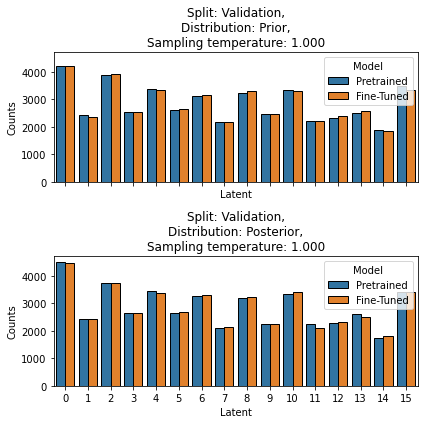

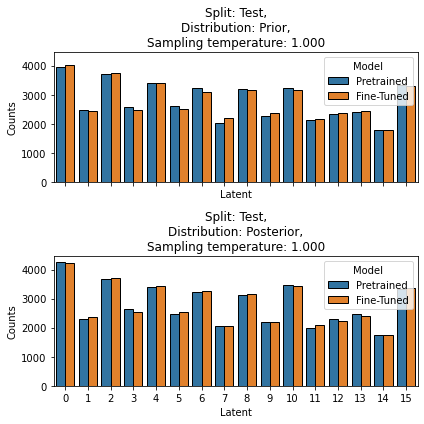

In [102]:
for split in sample_df_eval['Split'].unique():
    tmp_df = sample_df_eval[sample_df_eval['Split'] == split]
    
    fig, axes = plt.subplots(
        nrows=len(tmp_df['Distribution'].unique()), 
        ncols=len(tmp_df['Sampling temperature'].unique()), 
        figsize=(6, 6), 
        sharex=True, 
        sharey=True
    )

    for i, (distribution, distribution_df) in enumerate(tmp_df.groupby('Distribution', sort=False)):
        for j, (t, temperature_df) in enumerate(distribution_df.groupby('Sampling temperature', sort=False)):
            sns.barplot(data=temperature_df, hue='Model', x='Latent', y='Counts', ax=axes[i], linewidth=1., edgecolor='0', order=[*range(N_LATENTS)])
            axes[i].set_title(f'Split: {split},\nDistribution: {distribution},\nSampling temperature: {t:.3f}')
            # axes[i][j].set_xlabel('Latent')
            # axes[i][j].set_ylabel('Counts')
            # axes[0][i].set_xlim(0.9, tmp_df_coarse[0].max() + 1000)
    plt.tight_layout()
    plt.show()

#### Extrinsic evaluation

In [111]:
tmp_df = df_eval[df_eval['Metric'].isin(extrinsic_metrics)]

In [113]:
metric_df.head()

,Sampling temperature,Fold,Metric,Score,Model,Distribution,Label,Vector,Split
30,1.0,None,V-Measure,0.001998,Pretrained,Prior,Corpus,None,test
31,1.0,None,V-Measure,0.004381,Pretrained,Posterior,Corpus,None,test
32,1.0,None,V-Measure,0.002451,Fine-Tuned,Prior,Corpus,None,test
33,1.0,None,V-Measure,0.004229,Fine-Tuned,Posterior,Corpus,None,test
34,1.0,None,V-Measure,0.000310,LDA,Prior,Corpus,None,test


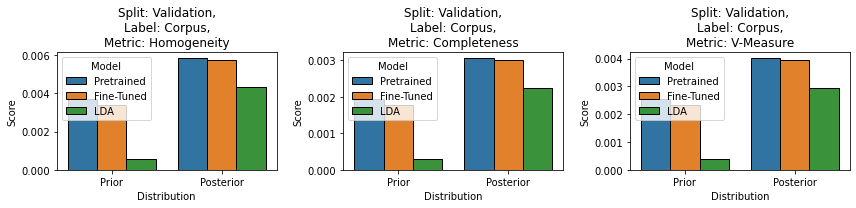

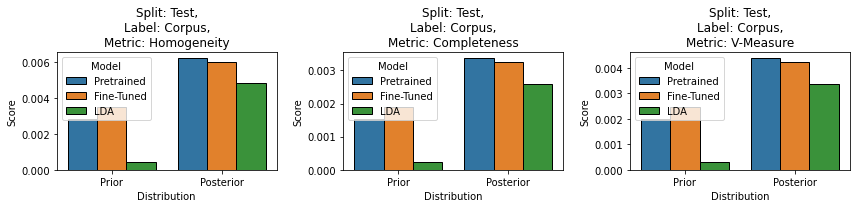

In [124]:
for split in tmp_df['Split'].unique():
    tmp_df_ = tmp_df[tmp_df['Split'] == split]
    
    fig, axes = plt.subplots(
        nrows=len(tmp_df_['Label'].unique()), 
        ncols=len(tmp_df_['Metric'].unique()), 
        figsize=(12, 3), 
        sharex=True, 
        # sharey=True
    )

    for i, (label, label_df) in enumerate(tmp_df_.groupby('Label', sort=False)):
        for j, (metric, metric_df) in enumerate(label_df.groupby('Metric', sort=False)):
            sns.barplot(
                data=metric_df, 
                hue='Model', 
                x='Distribution',  
                y='Score',
                ax=axes[j], 
                linewidth=1., 
                edgecolor='0'
            )
            axes[j].set_title(f'Split: {split.capitalize()},\nLabel: {label},\nMetric: {metric}')
    plt.tight_layout()
    plt.show()

#### Intrinsic evaluation

In [125]:
tmp_df = df_eval[df_eval['Metric'].isin(intrinsic_metrics)]

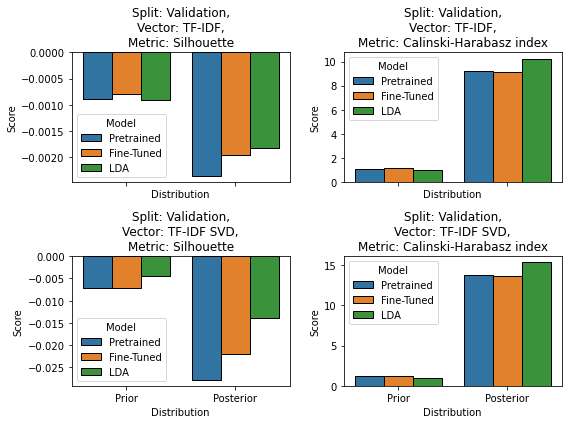

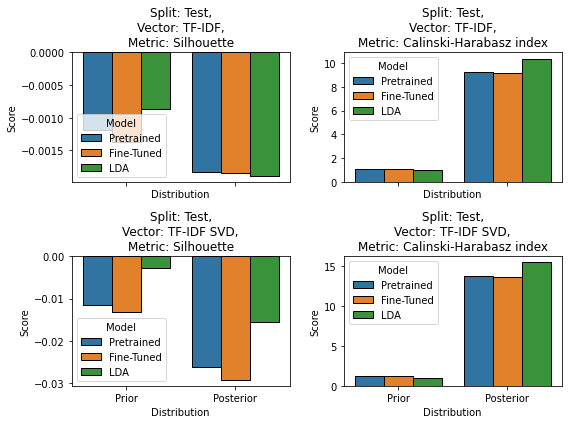

In [129]:
for split in tmp_df['Split'].unique():
    tmp_df_ = tmp_df[tmp_df['Split'] == split]
    
    fig, axes = plt.subplots(
        nrows=len(tmp_df_['Vector'].unique()), 
        ncols=len(tmp_df_['Metric'].unique()), 
        figsize=(8, 6), 
        sharex=True, 
        # sharey=True
    )

    for i, (vector, vector_df) in enumerate(tmp_df_.groupby('Vector', sort=False)):
        for j, (metric, metric_df) in enumerate(vector_df.groupby('Metric', sort=False)):
            sns.barplot(
                data=metric_df, 
                hue='Model', 
                x='Distribution',  
                y='Score',
                ax=axes[i][j], 
                linewidth=1., 
                edgecolor='0'
            )
            axes[i][j].set_title(f'Split: {split.capitalize()},\nVector: {vector},\nMetric: {metric}')
    plt.tight_layout()
    plt.show()

### Psychotherapy

We focus the anlysis on the labels for the HOPE corpus, for multiple reasons:
- It is the target data set
- We have labels so we can appl both an extrinsic and intrinsic evaluation
- Its size allows for repeated sampling validation

In [130]:
hope = {
    split: [
        sample 
        for sample in data[split] 
        if sample['corpus'] == 'HOPE' and sample['speaker'] is not None and sample['dialogue_act'] is not None
    ]
    for split in data
    if split != 'train'
}

#### Correlations

Look for correlations between high-level info a latent codes

In [ ]:
hli_df = pd.DataFrame(
    [
        [
            split.capitalize(), 
            sample['corpus'],
            DIALOGUE_ACT_ENCODER.get(DIALOGUE_ACT_MAP.get(sample.get('dialogue_act', None), None), None),
            DIALOGUE_ACT_TYPE_ENCODER.get(DIALOGUE_ACT_TYPE_MAP.get(sample.get('dialogue_act', None), None), None),
            SPEAKER_ENCODER.get(SPEAKER_MAP.get(sample.get('speaker', None), None), None),
            SENTIMENT_ENCODER.get(SENTIMENT_MAP.get(sample.get('sentiment', None), None), None)
        ] + sample['latent_prior_dist'] + sample['latent_posterior_dist']
        for split in hope for sample in hope[split]
    ], 
    columns=[
        'Split', 'Corpus', 'Dialogue act', 'Dialogue act type', 'Speaker', 'Sentiment'
    ] + [
        f'Latent code {i + 1} P' for i in range(N_LATENTS)
    ] + [
        f'Latent code {i + 1} Q' for i in range(N_LATENTS)
    ]
)

Validation

In [ ]:
sns.clustermap(
    pd.get_dummies(
        hli_df[hli_df['Split'] == 'Validation'], 
        columns=['Corpus', 'Dialogue act', 'Dialogue act type', 'Speaker', 'Sentiment']
    ).corr(), 
    vmin=-1, 
    vmax=1, 
    cmap=plt.colormaps['coolwarm']
)

Test

In [ ]:
sns.clustermap(
    pd.get_dummies(
        hli_df[hli_df['Split'] == 'Test'], 
        columns=['Corpus', 'Dialogue act', 'Dialogue act type', 'Speaker', 'Sentiment']
    ).corr(), 
    vmin=-1, 
    vmax=1, 
    cmap=plt.colormaps['coolwarm']
)

#### Clusters evaluation

We sample the latent ID $n$ from the prior and posterior distributions and we compute the usual clustering metrics, then we average the results

In [131]:
X = {split: tfidf.transform([sample['response'] for sample in hope[split]]) for split in hope}

In [132]:
X_embed = {split: svd.transform(X[split]) for split in X}

In [133]:
y = {
    split: {
        'Dialogue act': np.array([DIALOGUE_ACT_ENCODER[DIALOGUE_ACT_MAP[sample['dialogue_act']]] for sample in hope[split]]), 
        'Dialogue act type': np.array([DIALOGUE_ACT_TYPE_ENCODER[DIALOGUE_ACT_TYPE_MAP[sample['dialogue_act']]] for sample in hope[split]]), 
        'Speaker': np.array([SPEAKER_ENCODER[SPEAKER_MAP[sample['speaker']]] for sample in hope[split]]), 
        'Sentiment': np.array([SENTIMENT_ENCODER[SENTIMENT_MAP[sample['sentiment']]] for sample in hope[split]])
    } for split in hope
}

In [134]:
H = {
    split: {
            model: {
            DISTRIBUTION_MAP[distribution]: np.array([processed_data[model][split][hidden_state]])
            for distribution, hidden_state in zip(DISTRIBUTIONS, HIDDEN_VECTORS)
        } 
        for model in MODELS
    }
    for split in hope
}

In [135]:
log_p = {
    split: {
            model: {
            DISTRIBUTION_MAP[distribution]: torch.tensor(
                [sample[distribution] for sample in processed_data[model][split] if sample['corpus'] == 'HOPE' and sample['speaker'] is not None and sample['dialogue_act'] is not None]
            ).log() 
            for distribution in DISTRIBUTIONS
        } 
        for model in MODELS
    }
    for split in y
}

In [136]:
log_p_lda = {
    split: {
        'LDA': {
            'Prior': torch.tensor([[1 / N_LATENTS] * N_LATENTS] * len(hope[split])).log(),
            'Posterior': torch.tensor(lda.transform(tf.transform([sample['response'] for sample in hope[split]]))).log()
        } 
    }
    for split in hope
}

In [137]:
temperatures = [0.0, 0.333, 0.667, 0.9, 1.0, 1.5, 2.0]

In [138]:
values = []

In [139]:
extrinsic_metrics = {'Homogeneity': homogeneity_score, 'Completeness': completeness_score, 'V-Measure': v_measure_score}
intrinsic_metrics = {'Silhouette': silhouette_score, 'Calinski-Harabasz index': calinski_harabasz_score}

In [140]:
sampled_latents = []

In [141]:
for t in temperatures:
    for k in range(N_REPETITIONS):
        # Sample latent
        c = {
            split: {
                model: {
                    distribution: (
                        torch.multinomial(torch.softmax(log_probs / t, dim=-1), 1).squeeze().numpy()
                        if t > 0 else torch.argmax(log_probs, dim=-1).squeeze().numpy()
                    )
                    for distribution, log_probs in distribution_dict.items()
                } 
                for model, distribution_dict in model_dict.items()
            } 
            for split, model_dict in log_p.items()
        }
        # Add sampling with LDA to have a term of comparison
        c_lda = {
            split: {
                model: {
                    distribution: (
                        torch.multinomial(torch.softmax(log_probs / t, dim=-1), 1).squeeze().numpy()
                        if t > 0 else (
                            torch.argmax(log_probs, dim=-1).squeeze().numpy() 
                            if distribution == 'Posterior' else 
                            torch.multinomial(torch.softmax(log_probs, dim=-1), 1).squeeze().numpy()
                        )
                    )
                    for distribution, log_probs in distribution_dict.items()
                } 
                for model, distribution_dict in model_dict.items()
            } 
            for split, model_dict in log_p_lda.items()
        }
        # Store sampled latents
        for split in c:
            for model in c[split]:
                for distribution in c[split][model]:
                    for latent, count in zip(*np.unique(c[split][model][distribution], return_counts=True)):
                        sampled_latents.append((t, k, model, distribution, latent, count, split.capitalize()))
        # Extrinsic metrics
        for metric, f in extrinsic_metrics.items():
            for split in ['validation', 'test']:
                for model, model_dict in c[split].items():
                    for distribution, latent in model_dict.items():
                        for labelling, label in y[split].items():
                            values.append((t, k, metric, f(label, latent), model, distribution, labelling, None, split))
                for model, model_dict in c_lda[split].items():
                    for distribution, latent in model_dict.items():
                        for labelling, label in y[split].items():
                            values.append((t, k, metric, f(label, latent), model, distribution, labelling, None, split))
        # Intrinsic metrics
        for metric, f in intrinsic_metrics.items():
            for split in ['validation', 'test']:
                for model, model_dict in c[split].items():
                    for distribution, latent in model_dict.items():
                        values.append((t, k, metric, f(X[split].toarray(), latent), model, distribution, None, 'TF-IDF', split))
                        values.append((t, k, metric, f(X_embed[split], latent), model, distribution, None, 'TF-IDF SVD', split))
                        # values.append((t, k, metric, f(H[split][model][distribution], latent), model, distribution, None, 'Last hidden state', split))
                for model, model_dict in c_lda[split].items():
                    for distribution, latent in model_dict.items():
                        values.append((t, k, metric, f(X[split].toarray(), latent), model, distribution, None, 'TF-IDF', split))
                        values.append((t, k, metric, f(X_embed[split], latent), model, distribution, None, 'TF-IDF SVD', split))
                        # values.append((t, k, metric, f(H[split][model][distribution], latent), model, distribution, None, 'Last hidden state', split))

In [142]:
df = pd.DataFrame(values, columns=['Sampling temperature', 'Fold', 'Metric', 'Score', 'Model', 'Distribution', 'Label', 'Vector','Split'])

In [143]:
sample_df = pd.DataFrame(sampled_latents, columns=['Sampling temperature', 'Fold', 'Model', 'Distribution', 'Latent', 'Counts', 'Split'])

Plot the averaged distributions

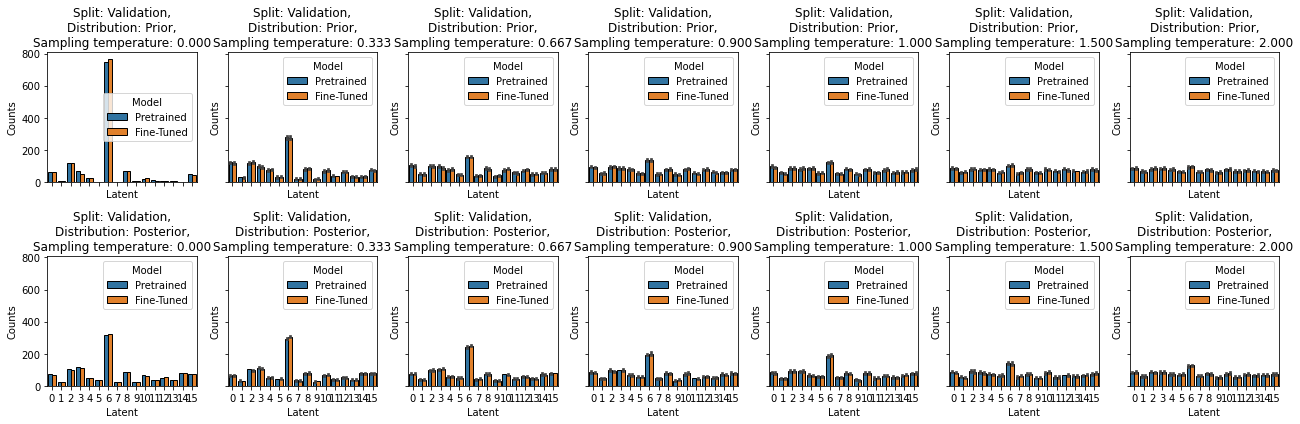

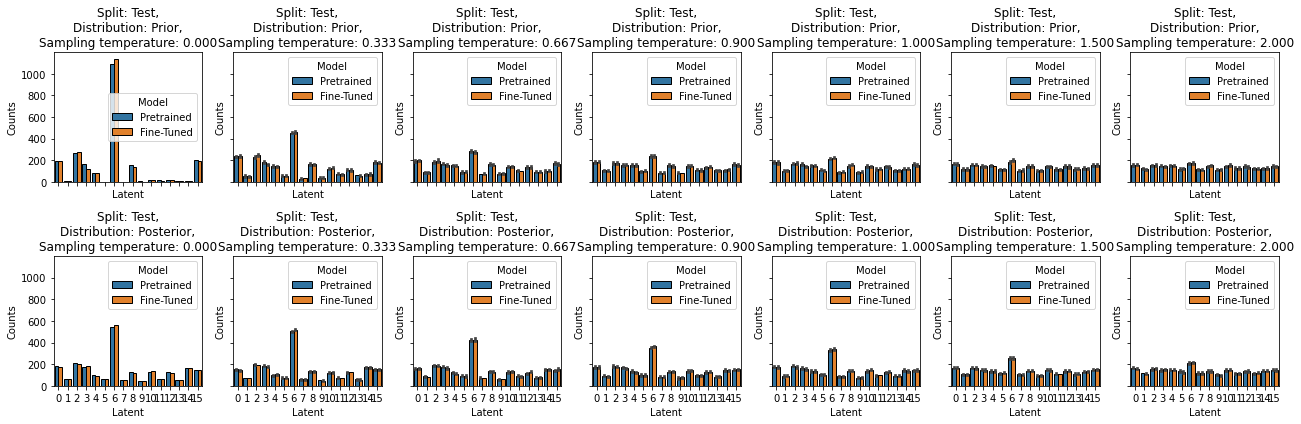

In [144]:
for split in sample_df['Split'].unique():
    tmp_df = sample_df[sample_df['Split'] == split]
    
    fig, axes = plt.subplots(
        nrows=len(tmp_df['Distribution'].unique()), 
        ncols=len(tmp_df['Sampling temperature'].unique()), 
        figsize=(18, 6), 
        sharex=True, 
        sharey=True
    )

    for i, (distribution, distribution_df) in enumerate(tmp_df.groupby('Distribution', sort=False)):
        for j, (t, temperature_df) in enumerate(distribution_df.groupby('Sampling temperature', sort=False)):
            sns.barplot(data=temperature_df, hue='Model', x='Latent', y='Counts', ax=axes[i][j], linewidth=1., edgecolor='0', order=[*range(N_LATENTS)])
            axes[i][j].set_title(f'Split: {split},\nDistribution: {distribution},\nSampling temperature: {t:.3f}')
            # axes[i][j].set_xlabel('Latent')
            # axes[i][j].set_ylabel('Counts')
            # axes[0][i].set_xlim(0.9, tmp_df_coarse[0].max() + 1000)
    plt.tight_layout()
    plt.show()

#### Extrinsic evaluation

In [145]:
tmp_df = df[df['Metric'].isin(extrinsic_metrics)]

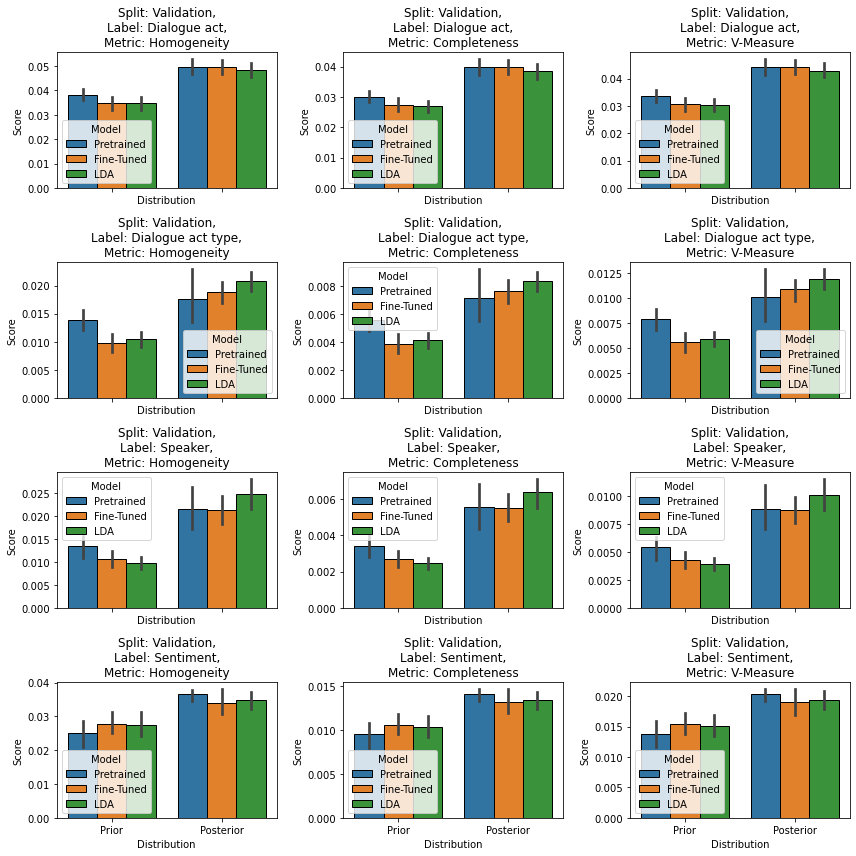

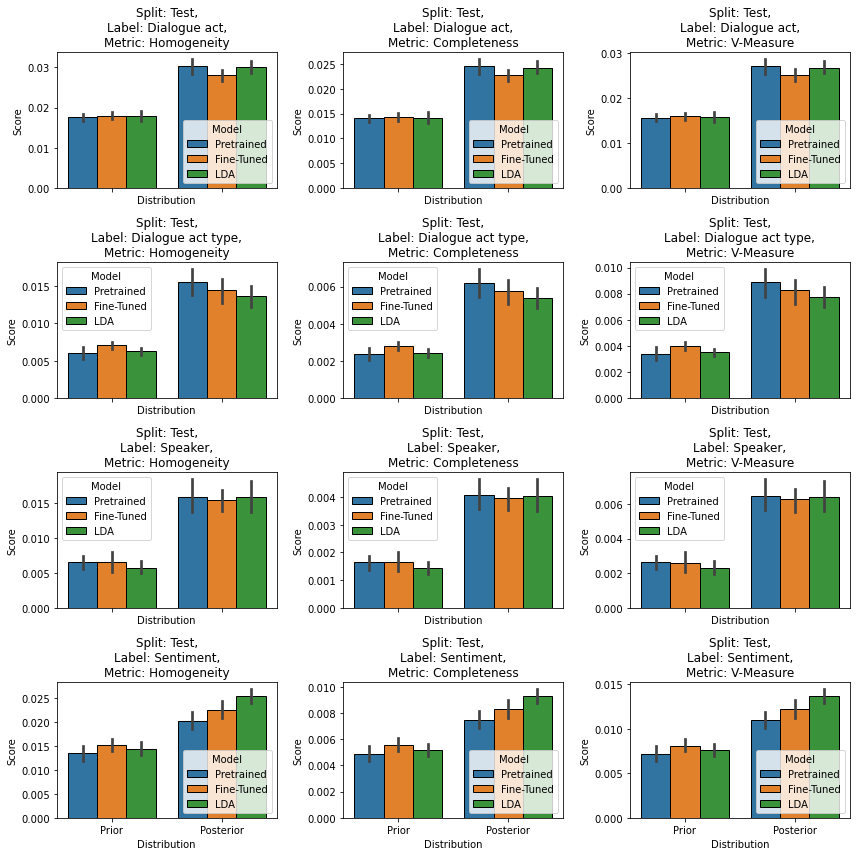

In [151]:
for split in tmp_df['Split'].unique():
    tmp_df_ = tmp_df[(tmp_df['Split'] == split) & (tmp_df['Sampling temperature'] == 1.0)]
    
    fig, axes = plt.subplots(
        nrows=len(tmp_df_['Label'].unique()), 
        ncols=len(tmp_df_['Metric'].unique()), 
        figsize=(12, 12), 
        sharex=True, 
        # sharey=True
    )

    for i, (label, label_df) in enumerate(tmp_df_.groupby('Label', sort=False)):
        for j, (metric, metric_df) in enumerate(label_df.groupby('Metric', sort=False)):
            sns.barplot(
                data=metric_df, 
                hue='Model', 
                x='Distribution',  
                y='Score',
                ax=axes[i][j], 
                linewidth=1., 
                edgecolor='0'
            )
            axes[i][j].set_title(f'Split: {split.capitalize()},\nLabel: {label},\nMetric: {metric}')
    plt.tight_layout()
    plt.show()

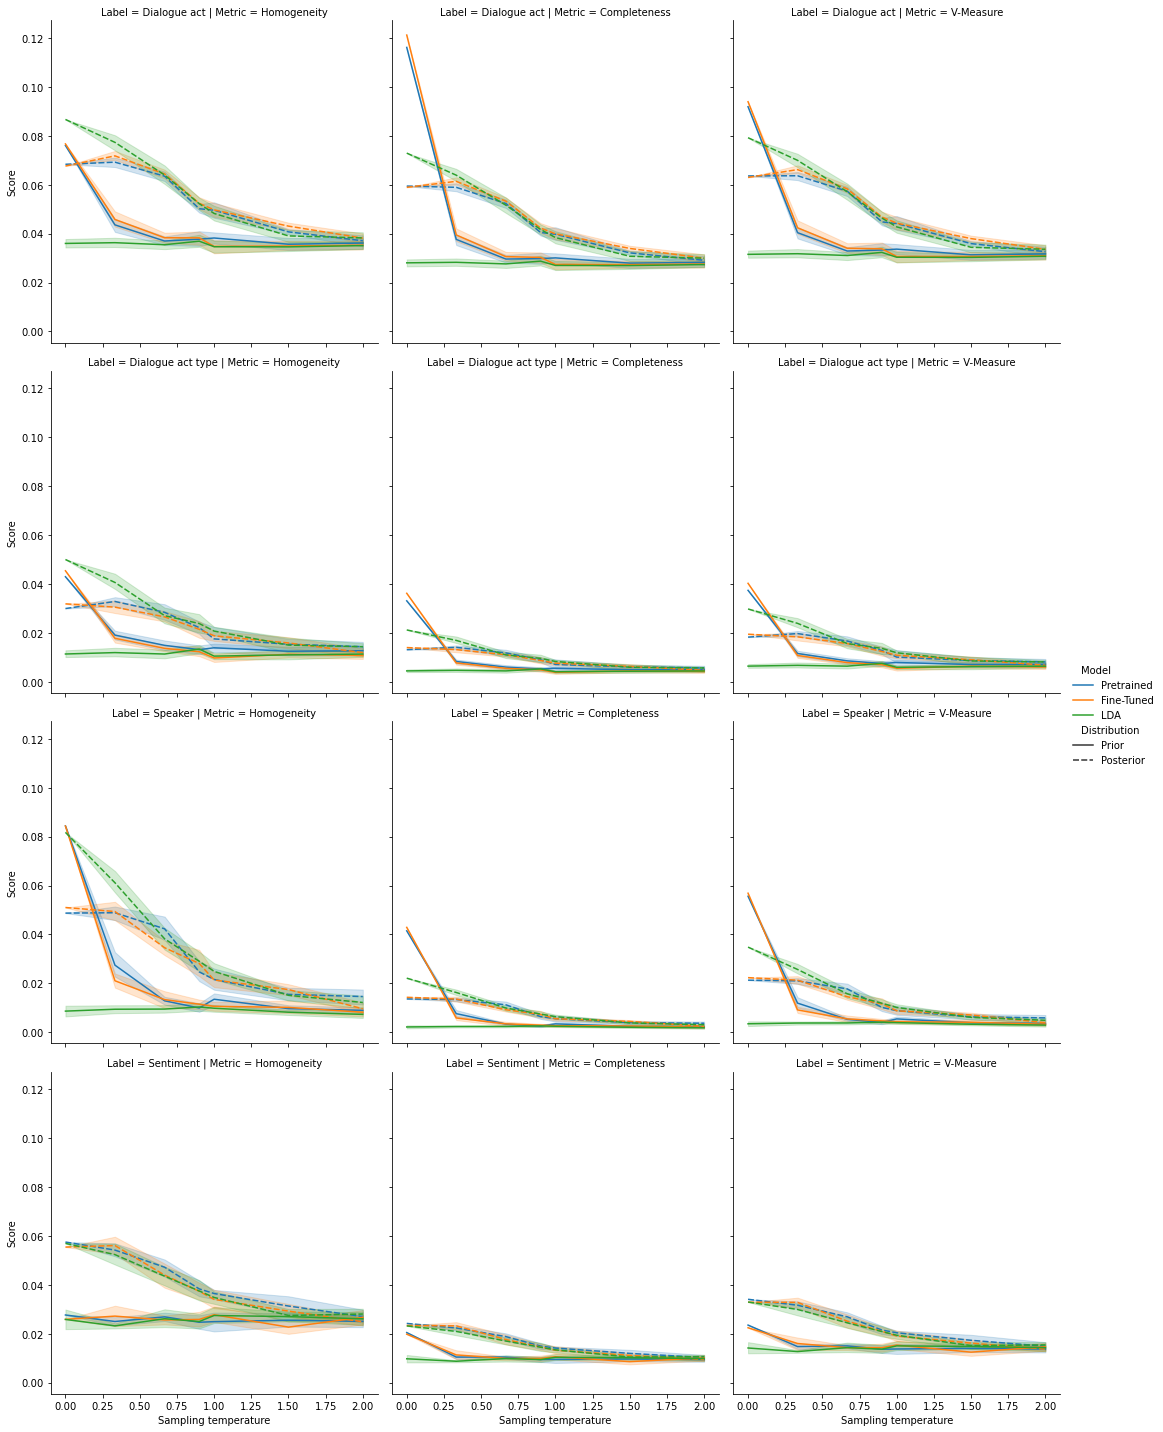

In [152]:
sns.relplot(
    data=tmp_df[tmp_df['Split'] == 'validation'], 
    x='Sampling temperature', 
    y='Score', 
    style='Distribution', 
    row='Label', 
    col='Metric', 
    hue='Model', 
    kind='line'
)

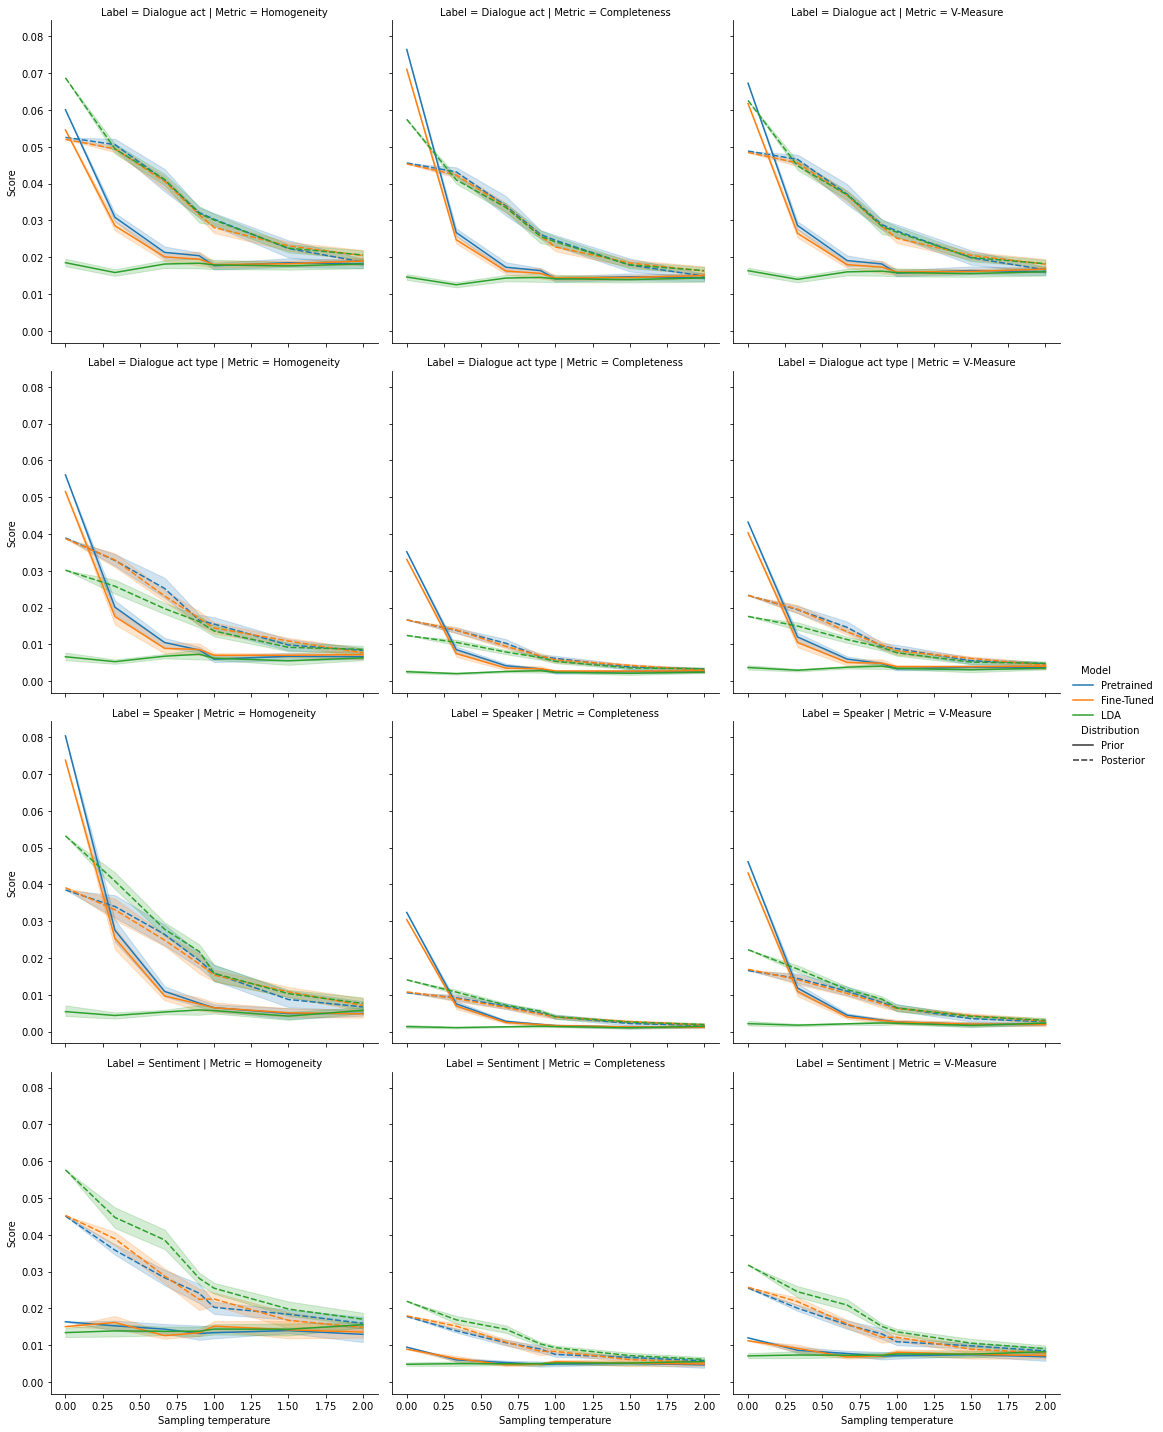

In [153]:
sns.relplot(
    data=tmp_df[tmp_df['Split'] == 'test'], 
    x='Sampling temperature', 
    y='Score', 
    style='Distribution', 
    row='Label', 
    col='Metric', 
    hue='Model', 
    kind='line'
)

#### Intrinsic evaluation

In [154]:
tmp_df = df[df['Metric'].isin(intrinsic_metrics)]

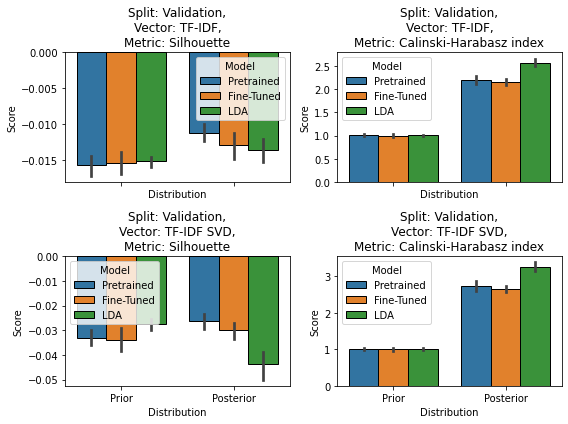

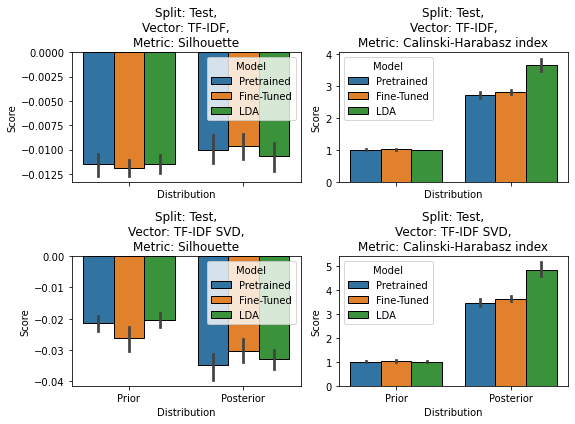

In [160]:
for split in tmp_df['Split'].unique():
    tmp_df_ = tmp_df[(tmp_df['Split'] == split) & (tmp_df['Sampling temperature'] == 1.0)]
    
    fig, axes = plt.subplots(
        nrows=len(tmp_df_['Vector'].unique()), 
        ncols=len(tmp_df_['Metric'].unique()), 
        figsize=(8, 6), 
        sharex=True, 
        # sharey=True
    )

    for i, (vector, vector_df) in enumerate(tmp_df_.groupby('Vector', sort=False)):
        for j, (metric, metric_df) in enumerate(vector_df.groupby('Metric', sort=False)):
            sns.barplot(
                data=metric_df, 
                hue='Model', 
                x='Distribution',  
                y='Score',
                ax=axes[i][j], 
                linewidth=1., 
                edgecolor='0'
            )
            axes[i][j].set_title(f'Split: {split.capitalize()},\nVector: {vector},\nMetric: {metric}')
    plt.tight_layout()
    plt.show()

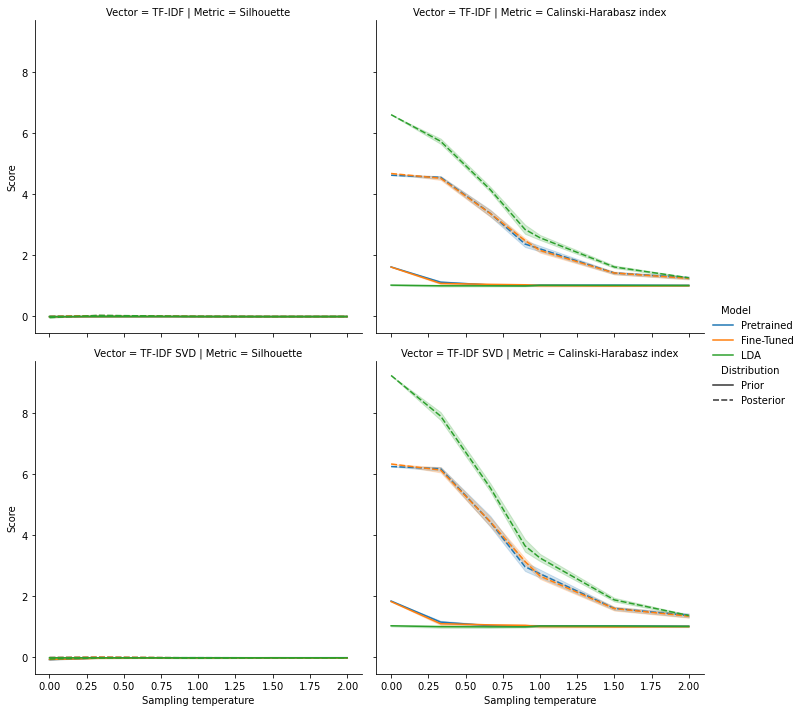

In [161]:
sns.relplot(
    data=tmp_df[tmp_df['Split'] == 'validation'], 
    x='Sampling temperature', 
    y='Score', 
    style='Distribution', 
    row='Vector',
    col='Metric', 
    hue='Model', 
    kind='line'
)

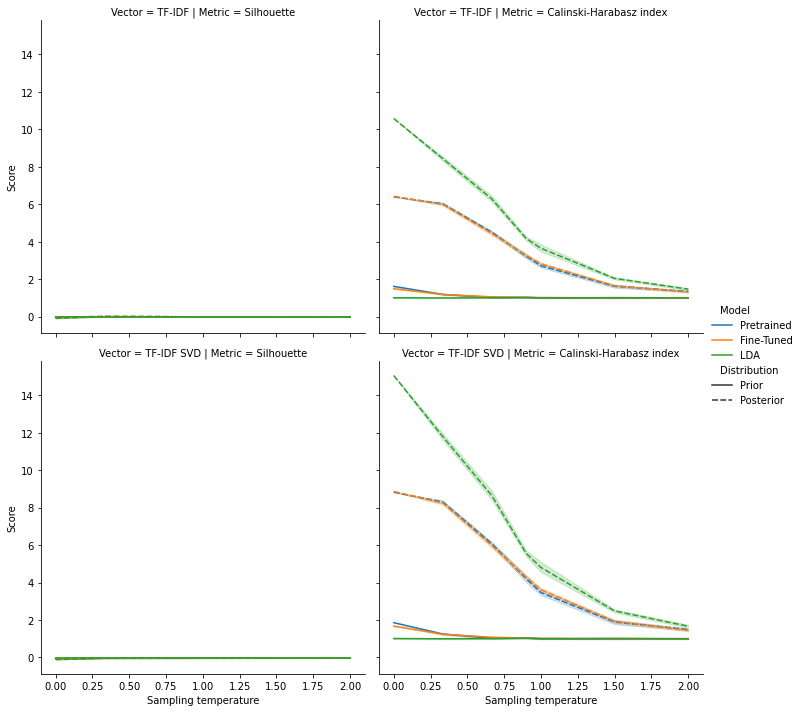

In [162]:
sns.relplot(
    data=tmp_df[tmp_df['Split'] == 'test'], 
    x='Sampling temperature', 
    y='Score', 
    style='Distribution', 
    row='Vector',
    col='Metric',  
    hue='Model', 
    kind='line'
)

### Terms distribution

In [163]:
X = {split: 
     {
         speaker: tfidf.transform(
             [sample['response'] for sample in samples]
         )
         for speaker, samples in group_by([s for s in hope[split] if s['corpus'] == 'HOPE' and s['speaker'] is not None and s['dialogue_act'] is not None], 'speaker').items()
     }
     for split in hope
}

In [164]:
hope_data_vectors = {
    split: {
        latent: {
            speaker: {
                DISTRIBUTION_MAP[distribution]: (X[split][speaker].toarray() * np.array([sample[distribution][latent] for sample in samples]).reshape(-1, 1))
                for distribution in DISTRIBUTIONS
            }
            for speaker, samples in group_by([s for s in samples if s['corpus'] == 'HOPE' and s['speaker'] is not None and s['dialogue_act'] is not None], 'speaker').items()
        }
        for latent in range(N_LATENTS)
    } 
    for split, samples in processed_data['Fine-Tuned'].items() if split != 'train'
}

In [172]:
vocabulary = tfidf.get_feature_names_out()

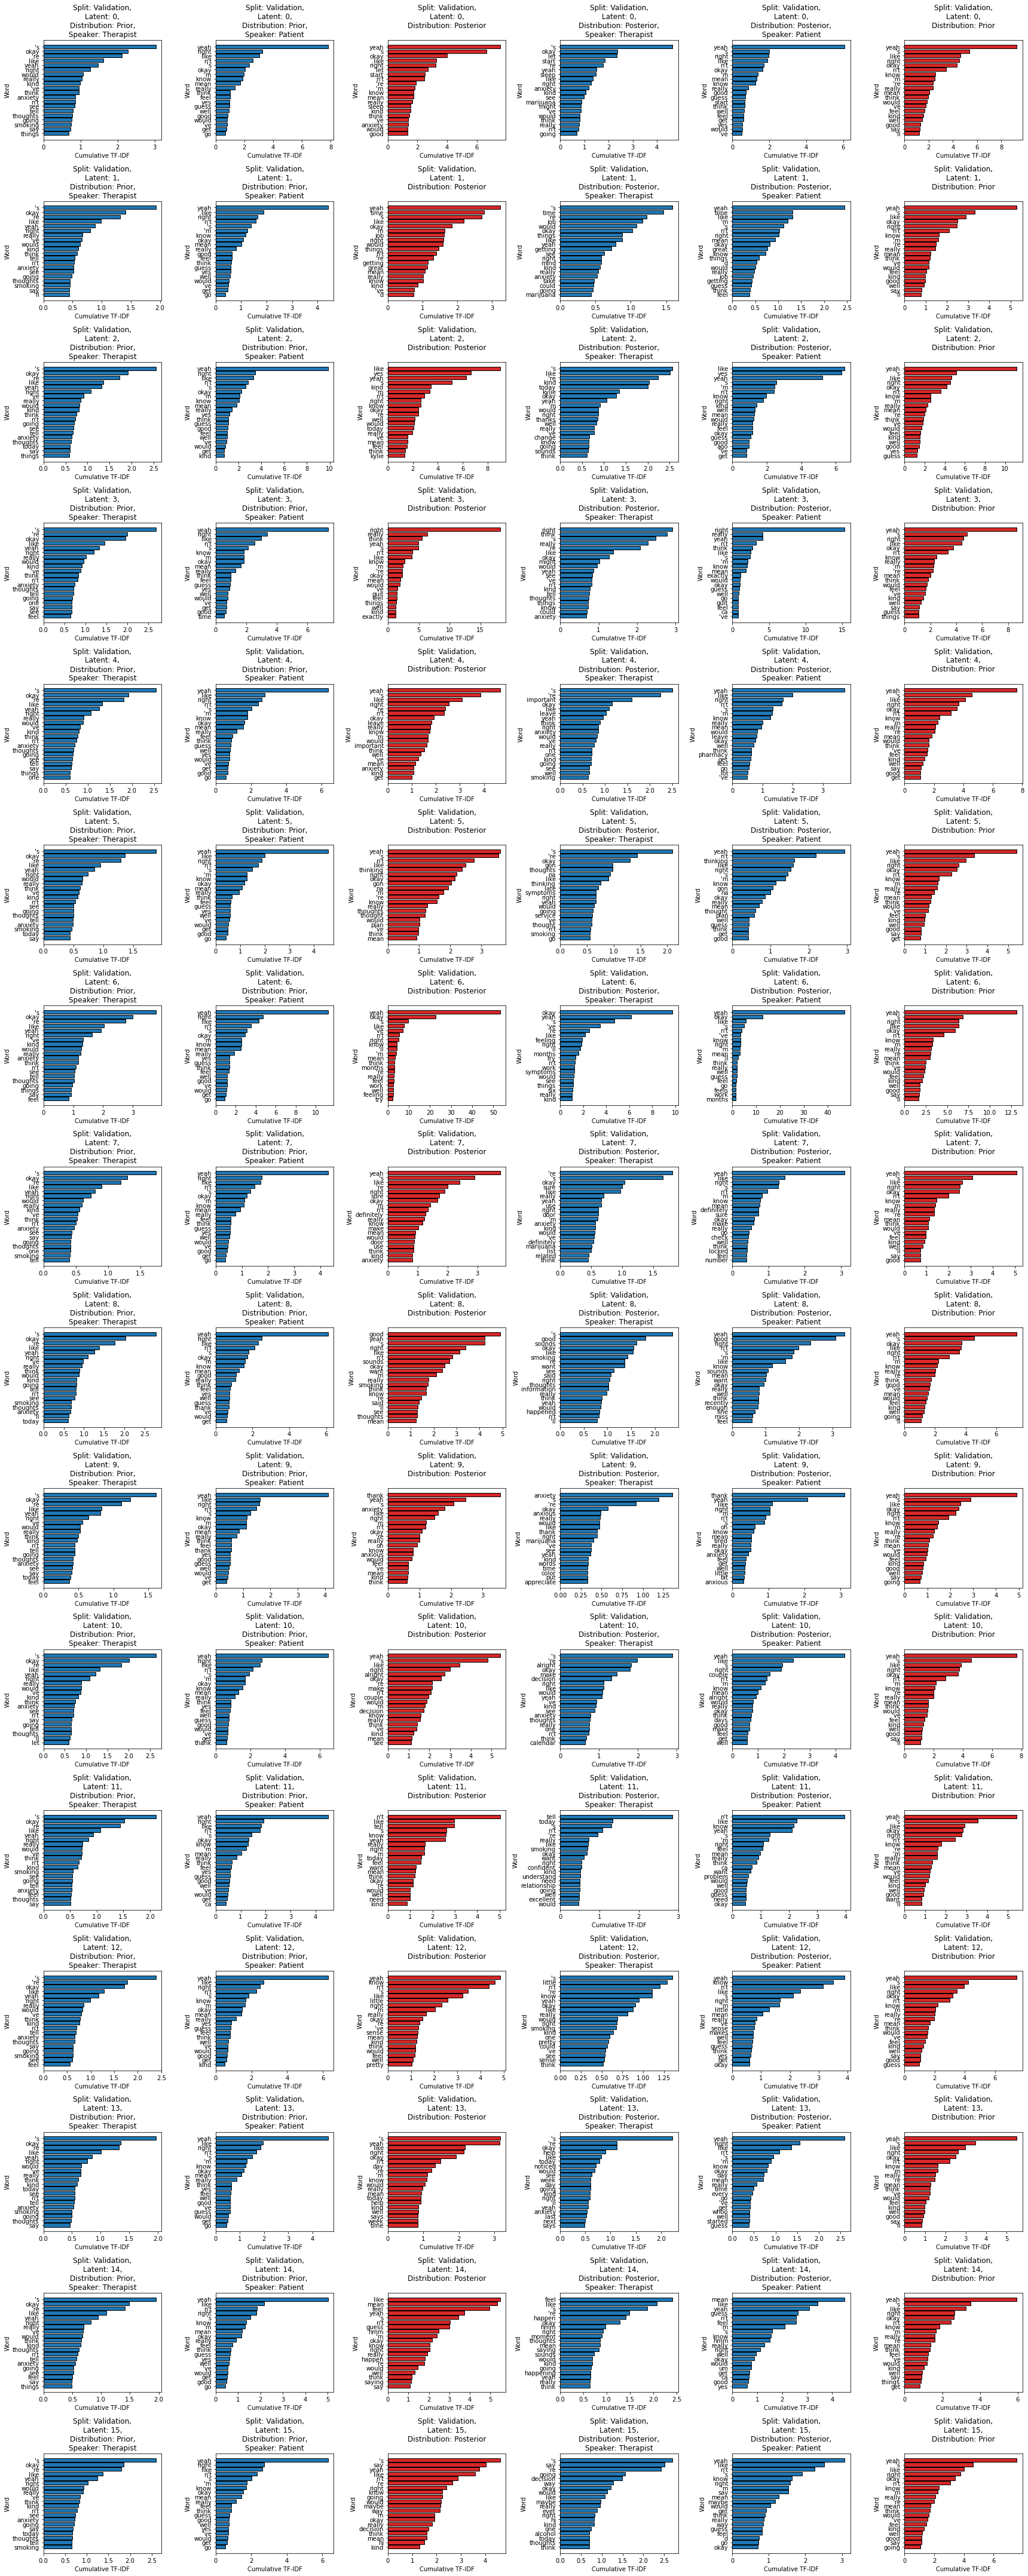

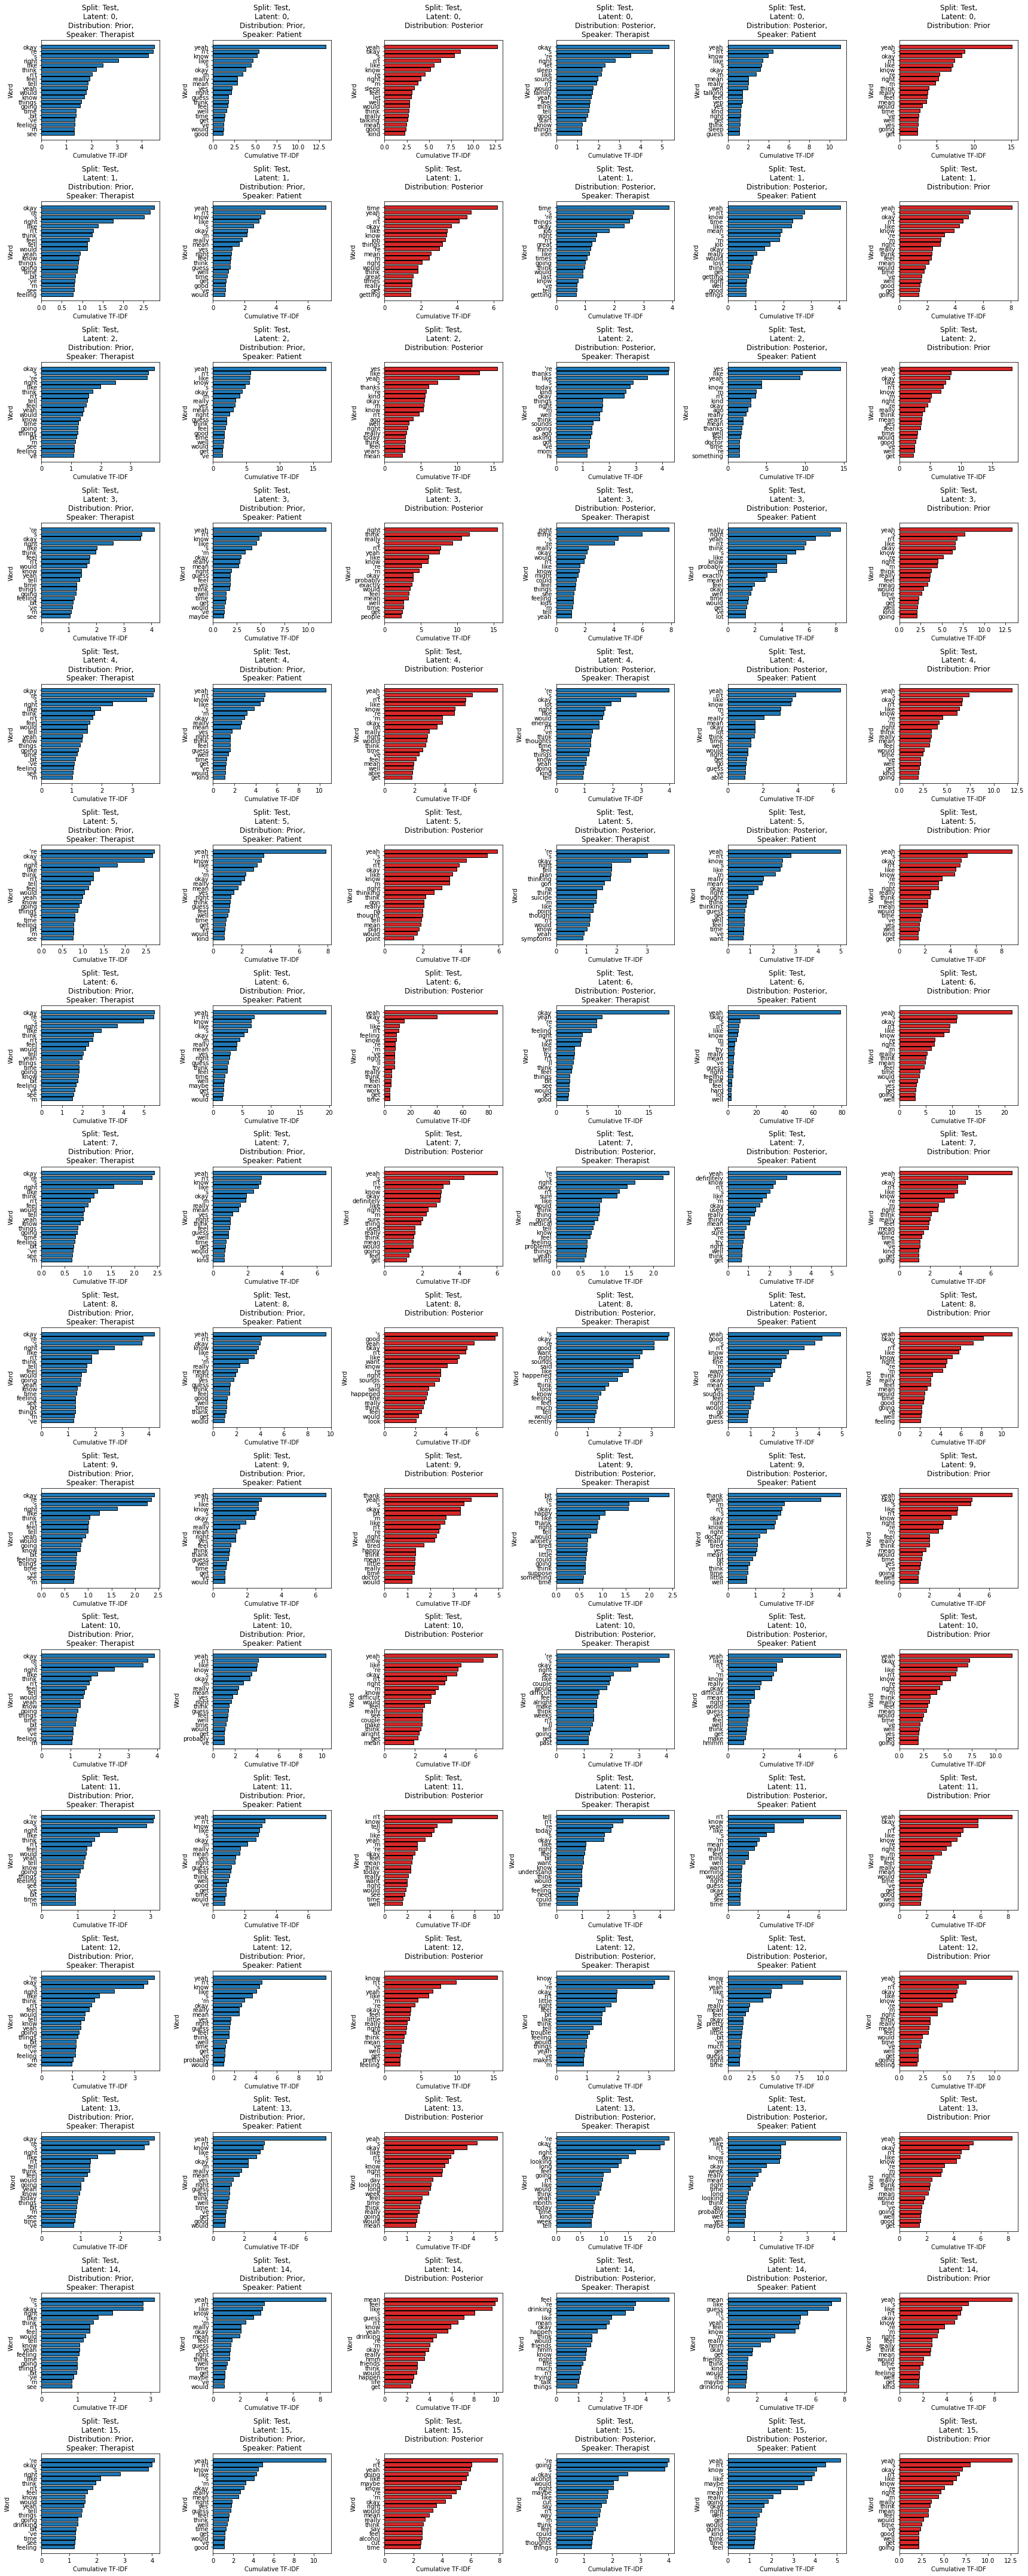

In [176]:
for i, (split, split_data) in enumerate(hope_data_vectors.items()):
    fig, axes = plt.subplots(nrows=16, ncols=6, figsize=(24, 60))
    for j, (latent, latent_data) in enumerate(split_data.items()):
        Z = {}
        for k, (speaker, speaker_data) in enumerate(latent_data.items()):
            for d, (distribution, disribution_data) in enumerate(speaker_data.items()):
                x = np.asarray(disribution_data.sum(0))
                if distribution in Z:
                    Z[distribution].append(x.copy())
                else:
                    Z[distribution] = [x.copy()]
                idxs = x.argsort()[: -TOP_WORDS - 1 : -1][::-1]
                x = x[idxs]
                y = vocabulary[idxs]
                axes[j][(3 * d) + k].barh(y, x, linewidth=1., edgecolor='0')
                axes[j][(3 * d) + k].set_title(f'Split: {split.capitalize()},\nLatent: {latent},\nDistribution: {distribution},\nSpeaker: {speaker}')
                axes[j][(3 * d) + k].set_xlabel('Cumulative TF-IDF')
                axes[j][(3 * d) + k].set_ylabel('Word')
        for d, (distribution, distribution_data) in enumerate(Z.items()):
            x = sum(distribution_data)
            idxs = x.argsort()[: -TOP_WORDS - 1 : -1][::-1]
            x = x[idxs]
            y = vocabulary[idxs]
            axes[j][(3 * d) - 1].barh(y, x, linewidth=1., edgecolor='0', color='tab:red')
            axes[j][(3 * d) - 1].set_title(f'Split: {split.capitalize()},\nLatent: {latent},\nDistribution: {distribution}\n')
            axes[j][(3 * d) - 1].set_xlabel('Cumulative TF-IDF')
            axes[j][(3 * d) - 1].set_ylabel('Word')
        
    plt.tight_layout()
    plt.show()